**5420 ANOMALY DETECTION**

**A8:** Modeling Strategies Assignment & Supervised ML

Zeying Liu (zl3121)

# Contents

>[Contents](#scrollTo=ekindqAaxQ-4)

>[Data Overview](#scrollTo=U-CWyawHreSP)

>[Data Processing](#scrollTo=0IvaVqWbcQaC)

>[Random Forest Modeling with H2O](#scrollTo=BaXJGevfg0fc)

>>[3.1 Test with small-scale sampling](#scrollTo=_B7Er44sH4Or)

>>[3.2 Apply model on the whole dataset](#scrollTo=35slJvh9N-GK)

>>>[3.2.1 Gains Table](#scrollTo=bGaLFqJ3pTLt)

>>>[3.2.2 Lift](#scrollTo=mSVyzrBNcvEy)

>>>[3.2.3 Kolmogorov-Smirnov (K-S)](#scrollTo=KCmaFAIHh9Dt)

>>>[3.2.4 ROC and PR Curves](#scrollTo=N5IGQ2IQwh-k)

>[Sampling](#scrollTo=Ba_x5SqP3iwa)

>>[4.1 Balance the whole dataset with H2O](#scrollTo=v4UiwLUViWRw)

>>[4.2 Under-sampling](#scrollTo=8IQqY_krJo-C)

>>>[4.2.1 ROC and PR Curves](#scrollTo=BnD24XTUR4xp)

>>[4.3 Over-sampling](#scrollTo=z4dBzlE8TtaW)

>>>[4.3.1 ROC and PR Curves](#scrollTo=nuNEtFvffAOG)

>[Insight](#scrollTo=smzOlEq5fYi5)

>>[5.1 Gains Table](#scrollTo=v7Z_o2l6jsSH)

>>[5.2 Lift](#scrollTo=mVJsKOGflhqp)

>>[5.3 K-S](#scrollTo=TrcQPl6hmItU)



# 1. Data Overview

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df.tail()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [2]:
# Check the distribution of y
df['loan_default'].value_counts()

0    64512
1    15488
Name: loan_default, dtype: int64

In [3]:
# Check all variables' name
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'loan_default', 'AP001', 'AP002',
       'AP003', 'AP004', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009', 'TD001',
       'TD002', 'TD005', 'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004',
       'CR005', 'CR009', 'CR012', 'CR015', 'CR017', 'CR018', 'CR019', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005', 'MB007'],
      dtype='object')

# 2. Data Processing

In [4]:
# Drop the duplicate columns
df = df.drop('Unnamed: 0', axis='columns')
df = df.drop('Unnamed: 0.1', axis='columns')

In [5]:
# Split data (60% in training, 40% in testing)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.40, random_state=42)
train.shape

(48000, 87)

In [6]:
# Check the distribution of variables
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
MB     2
id     1
lo     1
Name: source, dtype: int64

In [7]:
# Caregorize variables, and remove a bad data field: AP004
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
# Check values in AP list
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [8]:
# Check the distribution of y in train
train['loan_default'].value_counts()

0    38736
1     9264
Name: loan_default, dtype: int64

# 3. Random Forest Modeling with H2O

**What is Random forest ?**

Random forest is a type of bagging, which avoids the problem of overfitting by randomly selecting multiple subsets and averaging the results of each subset tree model.


In [ ]:
# Install package
!pip install h2o

In [10]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpq7evlb_4
  JVM stdout: /tmp/tmpq7evlb_4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpq7evlb_4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_mr1ob1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [11]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
# Set important parameters
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

## 3.1 Test with small-scale sampling

In [12]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [38]:
# Apply random forest model
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 350, # modify 1: higher AUC
        nfolds=10, # modify 2: no difference for this dataset
        min_rows=100,
        seed=1234)

# Use the cut of training dataset
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [TD054, TD051, TD062, TD061, CR012, TD048, AP005, TD055]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,350.0,350.0,126123.0,6.0,11.0,7.674286,19.0,25.0,22.465714




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14767884821774976
RMSE: 0.3842900574016322
MAE: 0.2959032667812424
RMSLE: 0.2694401589332627
Mean Residual Deviance: 0.14767884821774976

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14786750095953943
RMSE: 0.38453543524562134
MAE: 0.2961128910112377
RMSLE: 0.26963416242086236
Mean Residual Deviance: 0.14786750095953943

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,...,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
0,mae,0.296080,0.014221,0.288175,0.301281,0.286590,0.296227,0.305950,0.322543,0.282144,...,0.290000,0.276041,0.315560,0.305323,0.280429,0.309434,0.285602,0.287274,0.277877,0.312376
1,mean_residual_deviance,0.147786,0.014852,0.139376,0.154846,0.141049,0.145674,0.157822,0.176227,0.127300,...,0.141950,0.128994,0.166420,0.160848,0.134811,0.158850,0.136896,0.137017,0.128081,0.167589
2,mse,0.147786,0.014852,0.139376,0.154846,0.141049,0.145674,0.157822,0.176227,0.127300,...,0.141950,0.128994,0.166420,0.160848,0.134811,0.158850,0.136896,0.137017,0.128081,0.167589
3,r2,0.026183,0.022621,-0.017981,0.050991,0.029451,0.035152,0.060561,0.009681,0.010560,...,0.034785,0.010614,0.037139,0.039696,0.025767,0.039186,0.014348,0.020396,0.071343,0.021814
4,residual_deviance,0.147786,0.014852,0.139376,0.154846,0.141049,0.145674,0.157822,0.176227,0.127300,...,0.141950,0.128994,0.166420,0.160848,0.134811,0.158850,0.136896,0.137017,0.128081,0.167589
5,rmse,0.383971,0.019252,0.373330,0.393504,0.375565,0.381673,0.397268,0.419794,0.356791,...,0.376763,0.359157,0.407947,0.401058,0.367166,0.398560,0.369995,0.370158,0.357884,0.409377
6,rmsle,0.269403,0.010219,0.265799,0.272776,0.264166,0.268400,0.274827,0.289406,0.256450,...,0.265117,0.256076,0.281968,0.277054,0.260105,0.276979,0.262670,0.262817,0.253135,0.282749



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-07-20 23:49:12,1 min 46.429 sec,0.0,NaN,NaN,NaN
1,,2022-07-20 23:49:12,1 min 46.444 sec,1.0,0.392031,0.296257,0.153688
2,,2022-07-20 23:49:12,1 min 46.456 sec,2.0,0.394203,0.297005,0.155396
3,,2022-07-20 23:49:12,1 min 46.470 sec,3.0,0.390428,0.293980,0.152434
4,,2022-07-20 23:49:12,1 min 46.486 sec,4.0,0.390176,0.294947,0.152237
5,,2022-07-20 23:49:12,1 min 46.501 sec,5.0,0.390452,0.296776,0.152453
6,,2022-07-20 23:49:12,1 min 46.512 sec,6.0,0.389836,0.296623,0.151972
7,,2022-07-20 23:49:12,1 min 46.532 sec,7.0,0.389143,0.296634,0.151432
8,,2022-07-20 23:49:12,1 min 46.545 sec,8.0,0.388235,0.295445,0.150727
9,,2022-07-20 23:49:12,1 min 46.563 sec,9.0,0.387240,0.295505,0.149955



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,1869.547485,1.000000,0.167996
1,MB007,1583.542725,0.847019,0.142296
2,TD009,1457.023071,0.779345,0.130927
3,TD005,747.806763,0.399993,0.067197
4,AP003,593.156921,0.317273,0.053301
5,TD014,482.124298,0.257883,0.043323
6,AP001,362.037842,0.193650,0.032532
7,CR019,323.660095,0.173122,0.029084
8,CR009,309.501831,0.165549,0.027812
9,TD010,287.489685,0.153775,0.025834



See the whole table with table.as_data_frame()


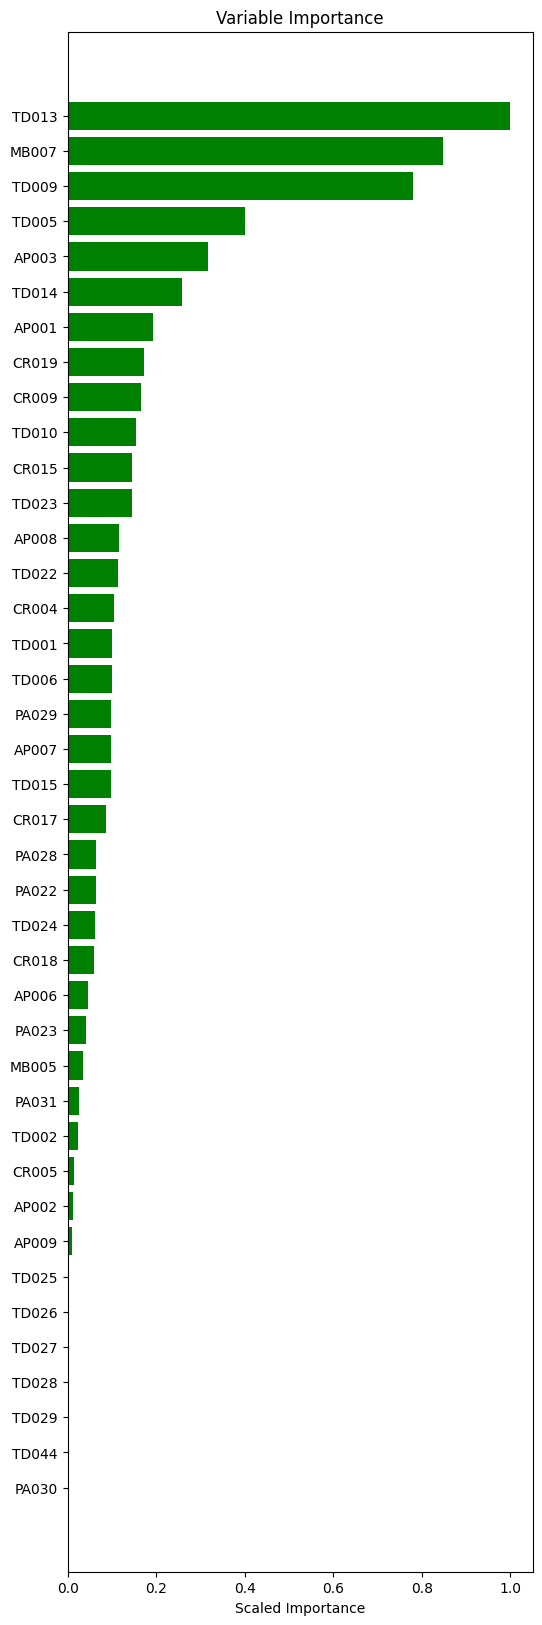

In [41]:
# Visualize the result of the importance of the varibales
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

Based on the visualization results, it can be seen that the top 3 variables with the greatest influence on the results are TD013, MB007, and TD009, and that the weight of these three variables is much higher than that of the other variables. TD009 is approximately twice the weight of the fourth variable TD005.

In [42]:
# Prediction
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "HASEE", "HTC", "IPAD4", "IVVI", "KINGSUN", "PROTRULY", "SMARTISAN", "YEPEN"]
  warnings.warn(w)


,loan_default,predict
0,0,0.273212
1,0,0.155773
2,0,0.120385
3,0,0.229023
4,0,0.122252


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "HASEE", "HTC", "IPAD4", "IVVI", "KINGSUN", "PROTRULY", "SMARTISAN", "YEPEN"]
  warnings.warn(w)


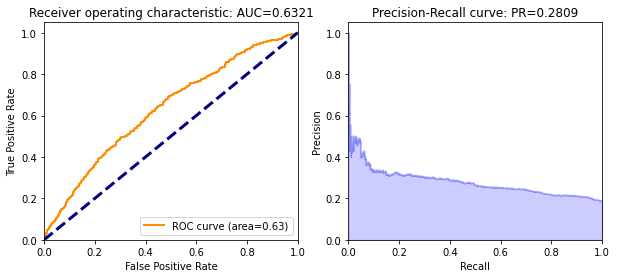

In [40]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (area=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

ROC_AUC(rf_v1,test_hex,'loan_default')

## 3.2 Apply model on the whole dataset

In [45]:
train_h20 = h2o.H2OFrame(train)
test_h20 = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 350,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_h20)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [CR012]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,350.0,350.0,1125581.0,13.0,19.0,15.014286,215.0,238.0,227.26857




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14790731524724277
RMSE: 0.38458720109650396
MAE: 0.2970844070795443
RMSLE: 0.2695640010890409
Mean Residual Deviance: 0.14790731524724277

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14801830960148077
RMSE: 0.38473147726886187
MAE: 0.29734714268394113
RMSLE: 0.26968008604803323
Mean Residual Deviance: 0.14801830960148077

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.297346,0.003789,0.295929,0.294494,0.299628,0.301697,0.299783,0.289900,0.294374,0.301848,0.299289,0.296514
1,mean_residual_deviance,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
2,mse,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
3,r2,0.049405,0.006087,0.055270,0.046501,0.055762,0.055862,0.041624,0.055527,0.046530,0.043911,0.041262,0.051805
4,residual_deviance,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
5,rmse,0.384698,0.005168,0.381663,0.380437,0.388051,0.390317,0.389396,0.375953,0.379169,0.390122,0.388013,0.383861
6,rmsle,0.269667,0.002859,0.267991,0.267539,0.270991,0.272289,0.272435,0.264342,0.267169,0.272847,0.271896,0.269169



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-07-21 00:05:41,11 min 37.481 sec,0.0,NaN,NaN,NaN
1,,2022-07-21 00:05:42,11 min 37.658 sec,1.0,0.393152,0.297051,0.154569
2,,2022-07-21 00:05:42,11 min 37.834 sec,2.0,0.390960,0.297208,0.152850
3,,2022-07-21 00:05:42,11 min 38.020 sec,3.0,0.389839,0.297286,0.151975
4,,2022-07-21 00:05:42,11 min 38.212 sec,4.0,0.389004,0.297171,0.151324
5,,2022-07-21 00:05:42,11 min 38.392 sec,5.0,0.388664,0.297400,0.151060
6,,2022-07-21 00:05:42,11 min 38.563 sec,6.0,0.388050,0.297147,0.150583
7,,2022-07-21 00:05:43,11 min 38.735 sec,7.0,0.387345,0.296835,0.150037
8,,2022-07-21 00:05:43,11 min 38.915 sec,8.0,0.387286,0.296965,0.149991
9,,2022-07-21 00:05:43,11 min 39.097 sec,9.0,0.387098,0.297129,0.149845



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,21562.953125,1.000000,0.158015
1,AP003,17060.833984,0.791210,0.125023
2,MB007,14256.062500,0.661137,0.104470
3,TD009,12746.745117,0.591141,0.093409
4,TD005,10917.308594,0.506299,0.080003
5,AP005,6619.749023,0.306996,0.048510
6,CR015,5949.373535,0.275907,0.043598
7,TD014,4992.437988,0.231528,0.036585
8,TD010,3399.326416,0.157647,0.024911
9,MB005,3209.523193,0.148844,0.023520



See the whole table with table.as_data_frame()


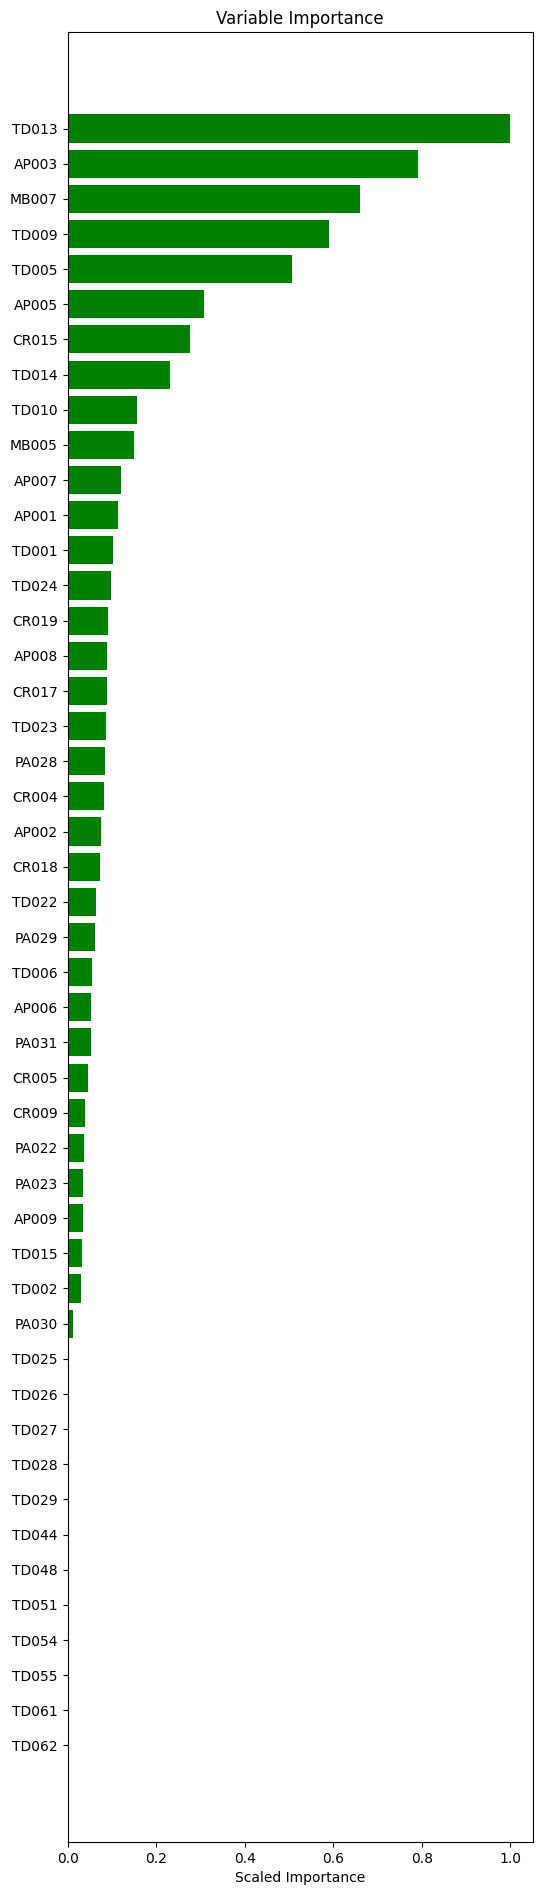

In [47]:
VarImp(rf_v2)

Based on the visualization results, it can be seen that the top 3 variables with the greatest influence on the results are TD013, AP003, and MB007, and that the weights of these 3 variables are not much higher than that of the other variables. The result of the whole dataset is quite different from the result of train_hex.

In [48]:
# Predict
predictions = rf_v2.predict(test_h20)
test_scores = test_h20['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/27 19:27", "2017/3/27 21:46", "2017/3/28 16:05", "2017/3/28 17:20", "2017/3/28 17:50", "2017/3/28 18:58", "2017/3/28 19:12", "2017/3/28 20:20", "2017/3/28 22:38", ...17081 not listed..., "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 8:52", "2017/7/9 8:57", "2017/7/9 8:58", "2017/7/9 9:42", "2017/7/9 9:46", "2017/7/9 9:55", "2017/7/9 9:57"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


,loan_default,predict
0,0,0.107980
1,0,0.185363
2,0,0.096575
3,1,0.219837
4,0,0.438751


In [49]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/29 15:33", "2017/3/30 10:29", "2017/3/30 11:19", "2017/3/30 16:03", "2017/3/30 17:57", "2017/3/31 11:10", "2017/3/31 13:10", "2017/3/31 17:24", "2017/3/31 17:49", "2017/3/31 19:09", ...1990 not listed..., "2017/7/9 18:06", "2017/7/9 18:32", "2017/7/9 18:56", "2017/7/9 19:32", "2017/7/9 1:27", "2017/7/9 22:02", "2017/7/9 23:27", "2017/7/9 23:41", "2017/7/9 5:09", "2017/7/9 8:29"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["HASEE", "KINGSUN", "PROTRULY", "YEPEN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.18,0.08,60.0,1.78,10.0,33.44
1,320,92,228,640,199,441,0.33,0.17,120.0,1.66,16.0,31.09
2,320,70,250,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,72,248,1280,341,939,0.57,0.36,240.0,1.42,21.0,26.64
4,320,68,252,1600,409,1191,0.68,0.46,300.0,1.36,22.0,25.56
5,320,58,262,1920,467,1453,0.78,0.56,360.0,1.30,22.0,24.32
6,320,46,274,2240,513,1727,0.86,0.66,420.0,1.22,20.0,22.90
7,320,44,276,2560,557,2003,0.93,0.77,480.0,1.16,16.0,21.76
8,320,23,297,2880,580,2300,0.97,0.88,540.0,1.07,9.0,20.14


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### **3.2.1 Gains Table**

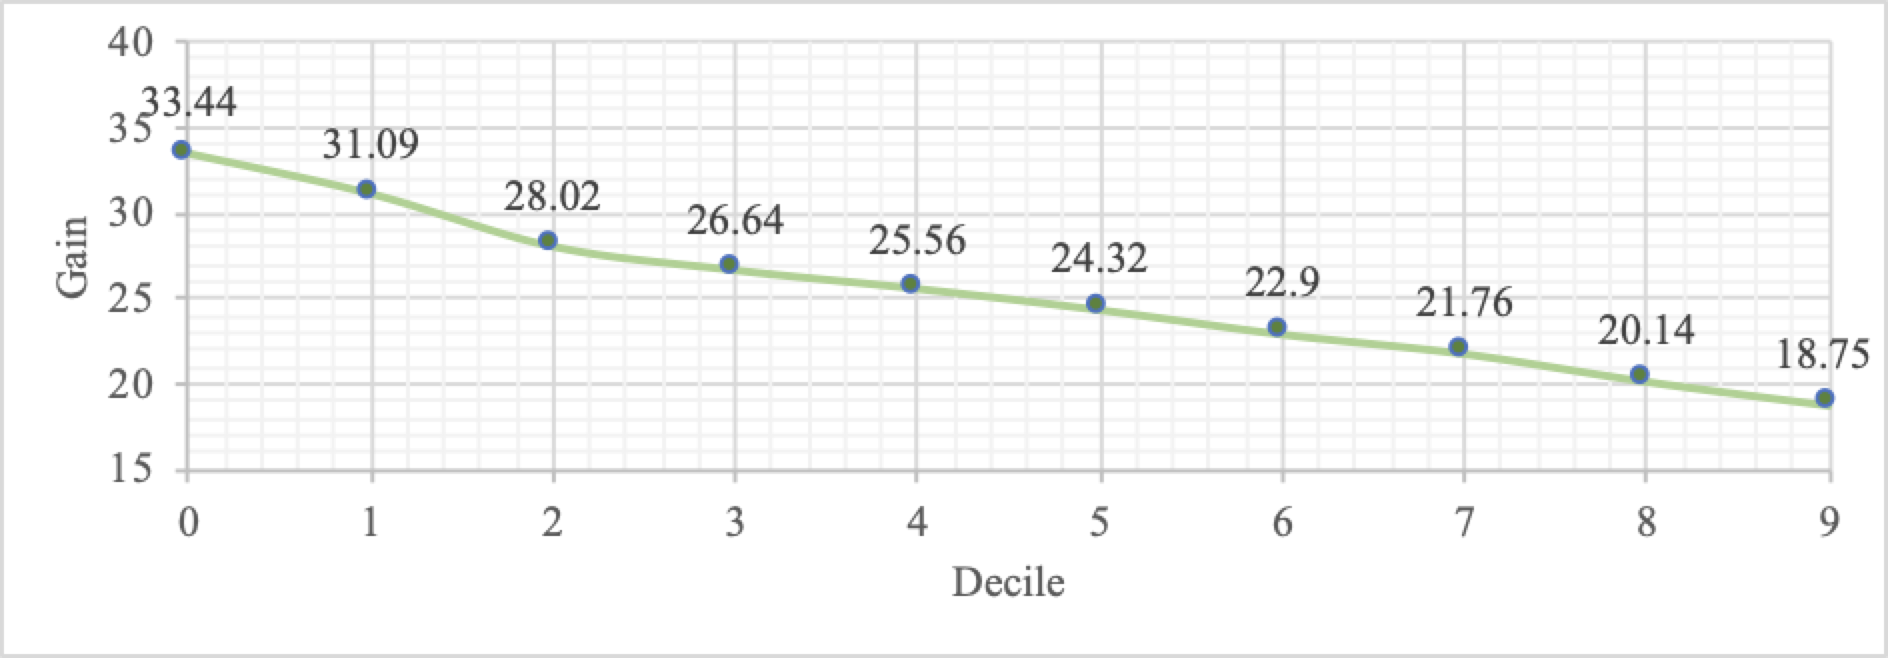

The purposes of gains table is to help analyst **select the model with better performance**, and **decide the segments should be focused on**.

According to the results, combining the mortgage business insight, there will be 33.44% (0.3344 * 320 = 107) customer in **decile 0** are bad loan applicants. 

Since *gain = cum_actual / cum_count*, the bank could avoid 74.38% (1 - 25.62%) of bad loan applicants by **avoiding lending to applicants in Decile 0 through Decile 4**.

(*cum_actual* refers to the cumulative number of people who are actually unable to repay the loan.)

### **3.2.2 Lift**



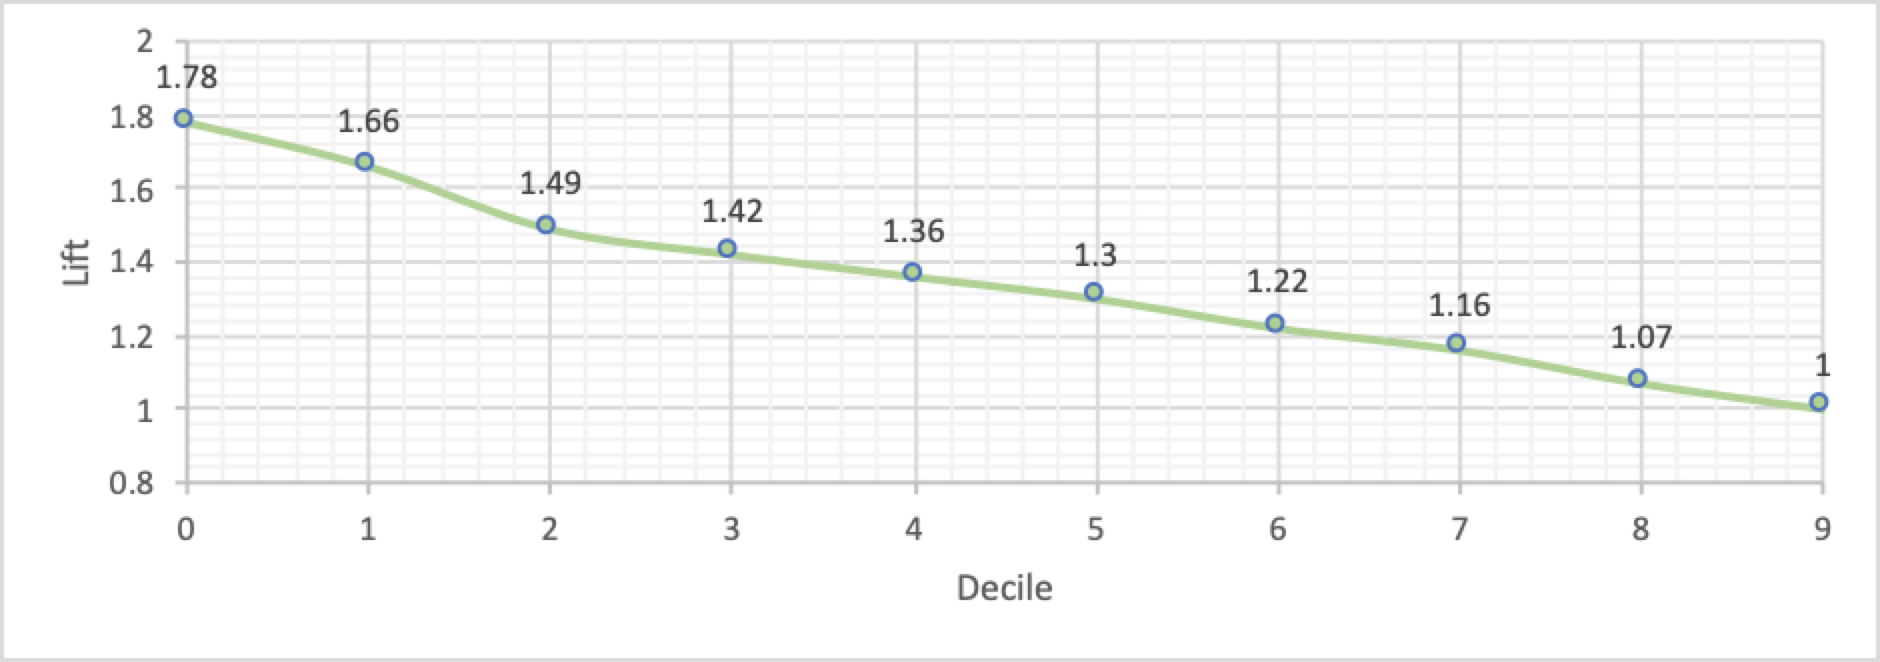

lift = cum_actual / if_random, which shows how much the bank can avoid bad applicants compared to banks randomly granting loans to customers.

Based on the results of the linear visualization between lift and Decile, it can be seen that the slope is most dramatic between Decile 1 to Decile 2. Therefore, from the lift perspective, the bank should **avoid applicants located through Decile 0 to Decile 2.**

### **3.2.3 Kolmogorov-Smirnov (K-S)**

K-S = |Cumultative % good — Cumulative % bad|, which measures the degree of separation between the distributions of the good and bad applicants.

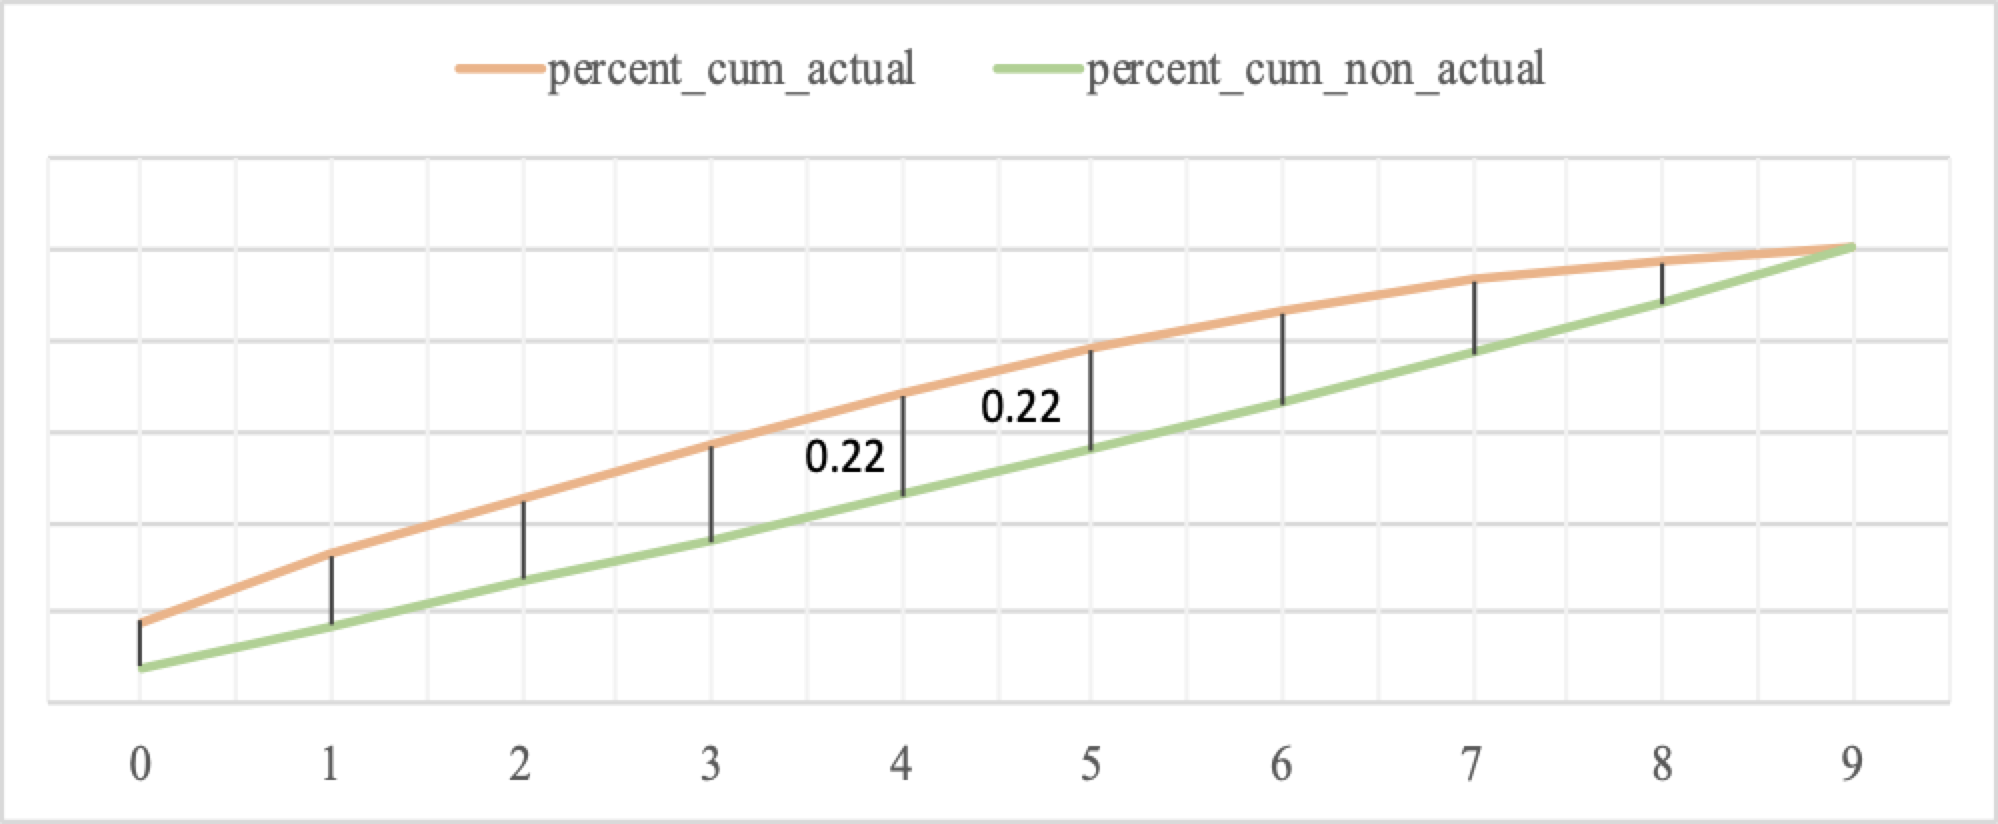

Frist of all, the K-S value for each deciles is not all 0, therefore the model effective to separate bad applicants from all customers. According to the figure above, I also find that the K-S values of Decile 4 and 5 reach to the maximum value of 0.22. In other words according to the results of K-S, the bank should **avoid applicants located through Decile 0 to Decile 4 or 5.**

### 3.2.4 ROC and PR Curves

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/27 19:27", "2017/3/27 21:46", "2017/3/28 16:05", "2017/3/28 17:20", "2017/3/28 17:50", "2017/3/28 18:58", "2017/3/28 19:12", "2017/3/28 20:20", "2017/3/28 22:38", ...17081 not listed..., "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 8:52", "2017/7/9 8:57", "2017/7/9 8:58", "2017/7/9 9:42", "2017/7/9 9:46", "2017/7/9 9:55", "2017/7/9 9:57"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


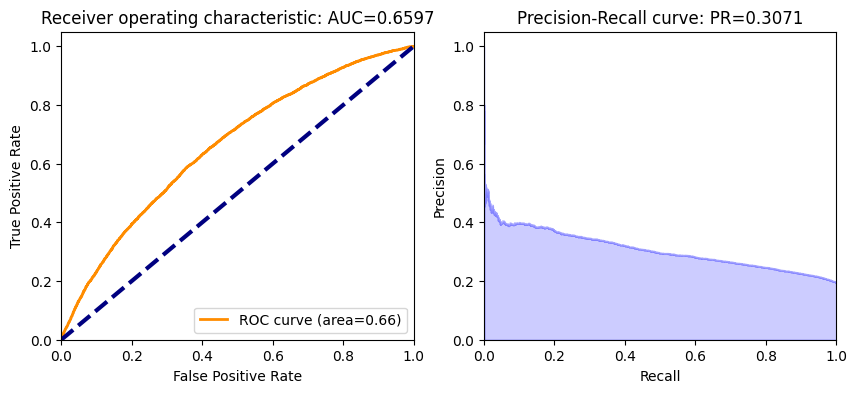

In [50]:
ROC_AUC(rf_v2,test_h20,'loan_default')

**`Interpretation:`**



**Receiver operating characteristic (ROC) curve** visualizes the accuracy of predictions for a whole range of cutoff values. The AUC value is 0.66 which means the performance of the model is **poor**.

**Precision-Recall (PR) curves**, on the other hand, is more informative than ROC when dealing with highly skewed datasets. Since the value of average precision for the PR curve is only 0.3071, the dataset is **skewed and needed to be balanced.**

# 4. Sampling

As analyzed above, the dataset is **imbalanced**. Because the data with **y=1 is much less than the data with y=0**. And such data is difficult to measure through ROC, because ROC is linear relationship between sensitivity and specificity. when one type of samples are significantly less than the other, single sample of under-sampling may have a huge effect on these two values, so ROC will have a large deviation. This is also the reason why this imbalanced dataset needs to further sampling.

## 4.1 Balance the whole dataset with H2O

H2O package can balance the dataset automaticly, processing both the under-sampling part and over-sampling part.

In [51]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 350,
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_h20)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [CR012]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,350.0,350.0,1125582.0,13.0,19.0,15.014286,215.0,238.0,227.26857




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14790731524724277
RMSE: 0.38458720109650396
MAE: 0.2970844070795443
RMSLE: 0.2695640010890409
Mean Residual Deviance: 0.14790731524724277

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14801830960148077
RMSE: 0.38473147726886187
MAE: 0.29734714268394113
RMSLE: 0.26968008604803323
Mean Residual Deviance: 0.14801830960148077

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.297346,0.003789,0.295929,0.294494,0.299628,0.301697,0.299783,0.289900,0.294374,0.301848,0.299289,0.296514
1,mean_residual_deviance,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
2,mse,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
3,r2,0.049405,0.006087,0.055270,0.046501,0.055762,0.055862,0.041624,0.055527,0.046530,0.043911,0.041262,0.051805
4,residual_deviance,0.148017,0.003967,0.145667,0.144732,0.150584,0.152347,0.151629,0.141341,0.143769,0.152196,0.150554,0.147350
5,rmse,0.384698,0.005168,0.381663,0.380437,0.388051,0.390317,0.389396,0.375953,0.379169,0.390122,0.388013,0.383861
6,rmsle,0.269667,0.002859,0.267991,0.267539,0.270991,0.272289,0.272435,0.264342,0.267169,0.272847,0.271896,0.269169



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-07-21 00:18:27,11 min 30.933 sec,0.0,NaN,NaN,NaN
1,,2022-07-21 00:18:27,11 min 31.290 sec,1.0,0.393152,0.297051,0.154569
2,,2022-07-21 00:18:27,11 min 31.643 sec,2.0,0.390960,0.297208,0.152850
3,,2022-07-21 00:18:28,11 min 32.001 sec,3.0,0.389839,0.297286,0.151975
4,,2022-07-21 00:18:28,11 min 32.348 sec,4.0,0.389004,0.297171,0.151324
5,,2022-07-21 00:18:28,11 min 32.703 sec,5.0,0.388664,0.297400,0.151060
6,,2022-07-21 00:18:29,11 min 33.109 sec,6.0,0.388050,0.297147,0.150583
7,,2022-07-21 00:18:29,11 min 33.563 sec,7.0,0.387345,0.296835,0.150037
8,,2022-07-21 00:18:29,11 min 33.786 sec,8.0,0.387286,0.296965,0.149991
9,,2022-07-21 00:18:30,11 min 33.982 sec,9.0,0.387098,0.297129,0.149845



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,21562.953125,1.000000,0.158015
1,AP003,17060.833984,0.791210,0.125023
2,MB007,14256.062500,0.661137,0.104470
3,TD009,12746.745117,0.591141,0.093409
4,TD005,10917.308594,0.506299,0.080003
5,AP005,6619.749023,0.306996,0.048510
6,CR015,5949.373535,0.275907,0.043598
7,TD014,4992.437988,0.231528,0.036585
8,TD010,3399.326416,0.157647,0.024911
9,MB005,3209.523193,0.148844,0.023520



See the whole table with table.as_data_frame()


In [52]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/29 15:33", "2017/3/30 10:29", "2017/3/30 11:19", "2017/3/30 16:03", "2017/3/30 17:57", "2017/3/31 11:10", "2017/3/31 13:10", "2017/3/31 17:24", "2017/3/31 17:49", "2017/3/31 19:09", ...1990 not listed..., "2017/7/9 18:06", "2017/7/9 18:32", "2017/7/9 18:56", "2017/7/9 19:32", "2017/7/9 1:27", "2017/7/9 22:02", "2017/7/9 23:27", "2017/7/9 23:41", "2017/7/9 5:09", "2017/7/9 8:29"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["HASEE", "KINGSUN", "PROTRULY", "YEPEN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.18,0.08,60.0,1.78,10.0,33.44
1,320,92,228,640,199,441,0.33,0.17,120.0,1.66,16.0,31.09
2,320,70,250,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,72,248,1280,341,939,0.57,0.36,240.0,1.42,21.0,26.64
4,320,68,252,1600,409,1191,0.68,0.46,300.0,1.36,22.0,25.56
5,320,58,262,1920,467,1453,0.78,0.56,360.0,1.30,22.0,24.32
6,320,46,274,2240,513,1727,0.86,0.66,420.0,1.22,20.0,22.90
7,320,44,276,2560,557,2003,0.93,0.77,480.0,1.16,16.0,21.76
8,320,23,297,2880,580,2300,0.97,0.88,540.0,1.07,9.0,20.14


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/27 19:27", "2017/3/27 21:46", "2017/3/28 16:05", "2017/3/28 17:20", "2017/3/28 17:50", "2017/3/28 18:58", "2017/3/28 19:12", "2017/3/28 20:20", "2017/3/28 22:38", ...17081 not listed..., "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 8:52", "2017/7/9 8:57", "2017/7/9 8:58", "2017/7/9 9:42", "2017/7/9 9:46", "2017/7/9 9:55", "2017/7/9 9:57"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


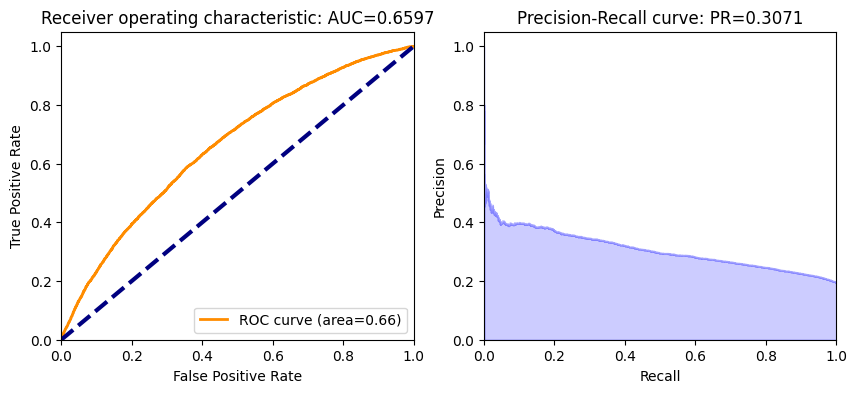

In [53]:
ROC_AUC(rf_v3,test_h20,'loan_default')

The values in the Gains table for model rf_v3, as well as the AUC value and average precision value are similar to rf_v2. Nothing has changed by using H2O package to balance the dataset.

## 4.2 Under-sampling

In this part, I would like to double the under-sampling data and testify whether this adjustment can improve the performance of the random forest model.

In [54]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

In [86]:
# Split data into testing(33%) and training(67%)
features = ['AP001', 'AP002','AP003', 'AP004', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009', 'TD001',
       'TD002', 'TD005', 'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004',
       'CR005', 'CR009', 'CR012', 'CR015', 'CR017', 'CR018', 'CR019', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005', 'MB007']

X = df[features]
y = df[target]

In [76]:
y1_cnt = df[target].sum()
y1_cnt

15488

In [88]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

30976

In [ ]:
!pip install imblearn

In [96]:
from imblearn.datasets import make_imbalance

X_loan, y_loan = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt, 0:y0_cnt},
                            random_state=0)
X_loan = pd.DataFrame(X_loan)
y_loan = pd.DataFrame(y_loan) 

In [97]:
y_loan = df[df[target]==1]
X_loan = df[df[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_loan,y_loan])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [94]:
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 350,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [CR012, AP005]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,350.0,350.0,1090098.0,12.0,18.0,14.22,206.0,227.0,217.94571




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.2067989630147946
RMSE: 0.4547515398707239
MAE: 0.41622708282984283
RMSLE: 0.3195452460408433
Mean Residual Deviance: 0.2067989630147946

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.2068241975768868
RMSE: 0.45477928446322924
MAE: 0.41641073349642693
RMSLE: 0.31956997072941884
Mean Residual Deviance: 0.2068241975768868

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.416408,0.001692,0.417591,0.418343,0.414734,0.415447,0.416333,0.415590,0.418158,0.418570,0.415742,0.413570
1,mean_residual_deviance,0.206825,0.001751,0.208341,0.208896,0.205055,0.205156,0.206368,0.205780,0.207946,0.209032,0.207526,0.204145
2,mse,0.206825,0.001751,0.208341,0.208896,0.205055,0.205156,0.206368,0.205780,0.207946,0.209032,0.207526,0.204145
3,r2,0.069145,0.005596,0.068947,0.073671,0.068071,0.062615,0.068513,0.076222,0.062229,0.061727,0.075687,0.073768
4,residual_deviance,0.206825,0.001751,0.208341,0.208896,0.205055,0.205156,0.206368,0.205780,0.207946,0.209032,0.207526,0.204145
5,rmse,0.454776,0.001926,0.456444,0.457051,0.452830,0.452942,0.454277,0.453630,0.456011,0.457201,0.455551,0.451824
6,rmsle,0.319565,0.000960,0.319894,0.319785,0.319001,0.319758,0.319850,0.318654,0.320851,0.321058,0.318774,0.318028



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-07-21 00:58:31,10 min 4.603 sec,0.0,NaN,NaN,NaN
1,,2022-07-21 00:58:31,10 min 4.739 sec,1.0,0.464265,0.416347,0.215542
2,,2022-07-21 00:58:31,10 min 4.882 sec,2.0,0.463226,0.416221,0.214579
3,,2022-07-21 00:58:31,10 min 5.025 sec,3.0,0.461827,0.416258,0.213284
4,,2022-07-21 00:58:31,10 min 5.169 sec,4.0,0.461279,0.416440,0.212778
5,,2022-07-21 00:58:31,10 min 5.307 sec,5.0,0.460396,0.416526,0.211965
6,,2022-07-21 00:58:32,10 min 5.448 sec,6.0,0.459570,0.416441,0.211205
7,,2022-07-21 00:58:32,10 min 5.607 sec,7.0,0.459020,0.416418,0.210699
8,,2022-07-21 00:58:32,10 min 5.747 sec,8.0,0.458505,0.416353,0.210227
9,,2022-07-21 00:58:32,10 min 5.897 sec,9.0,0.458152,0.416395,0.209903



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,40205.371094,1.000000,0.173504
1,AP003,32153.021484,0.799720,0.138755
2,TD009,29048.263672,0.722497,0.125356
3,MB007,22470.101562,0.558883,0.096969
4,TD005,16972.681641,0.422150,0.073245
5,CR015,12531.658203,0.311691,0.054080
6,TD014,9854.864258,0.245113,0.042528
7,TD010,4822.037109,0.119935,0.020809
8,MB005,4581.087402,0.113942,0.019769
9,TD023,4509.872070,0.112171,0.019462



See the whole table with table.as_data_frame()


### 4.2.1 ROC and PR Curves

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["KINGSUN"]
  warnings.warn(w)


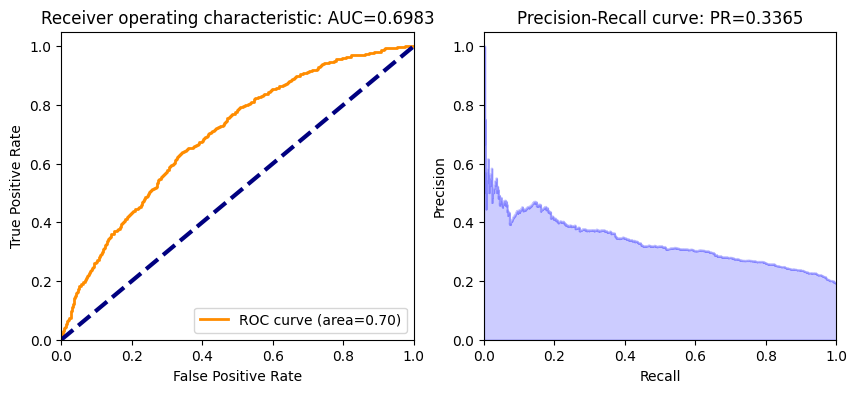

In [120]:
ROC_AUC(rf_v4,test_hex,'loan_default')

By doubling the data in the under-sampling section, or say the bad applicants, the values of both AUC and average precision increased while keeping the same parameters. They respectively increased from 0.65 to 0.69 and from 0.31 to 0.34.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "CHINAMOBILE", "DAQ", "FOPAD", "KDDI", "KONKA", "LEPHONE", "MANN", "MYTEL", "RAMOS", "REDGOO", "TINAI", "VETAS", "X6"]
  warnings.warn(w)


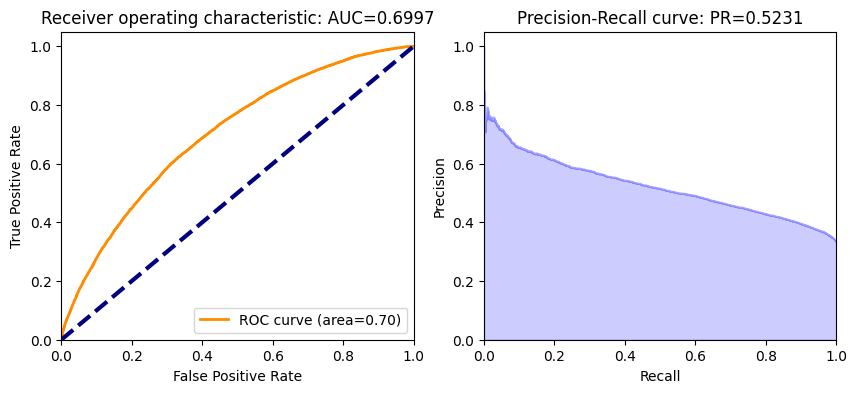

In [99]:
ROC_AUC(rf_v4,smpl_hex,'loan_default')

By comparing the results of the training and data sets, we can see that the average accuracy of the training set is significantly greater than that of the test set, indicating that there may still be an overfitting problem in the model.

## 4.3 Over-sampling

In this part, I would like to halve the over-sampling data and testify whether this adjustment can improve the performance of the random forest model.

In [111]:
y2_cnt = df[target].count() - df[target].sum()
y2_cnt

64512

In [112]:
N = 2
y3_cnt = y2_cnt / N
y3_cnt = int(y3_cnt)

In [116]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy={1: y3_cnt, 0: y2_cnt})
X_loan, y_loan = sampler.fit_resample(X, y)

X_loan = pd.DataFrame(X_loan)
y_loan = pd.DataFrame(y_loan) 

In [117]:
y_loan = df[df[target]==1]
X_loan = df[df[target]==0].sample(n=y3_cnt)
smp2 = pd.concat([X_loan,y_loan])
smp2_hex = h2o.H2OFrame(smp2)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [118]:
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 350,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v5.train(predictors,target,training_frame=smp2_hex)

drf Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [CR012, TD055, TD062]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v5


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,350.0,350.0,1126925.0,12.0,19.0,14.317142,210.0,237.0,226.18857




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20404271509653046
RMSE: 0.45171087555706524
MAE: 0.4106484373990903
RMSLE: 0.31737565737031004
Mean Residual Deviance: 0.20404271509653046

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.20409592499656748
RMSE: 0.4517697699011826
MAE: 0.4108474866252745
RMSLE: 0.31742431832385043
Mean Residual Deviance: 0.20409592499656748

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.410860,0.001759,0.413319,0.412346,0.407791,0.409234,0.411057,0.410910,0.411112,0.408835,0.412609,0.411382
1,mean_residual_deviance,0.204107,0.001661,0.205820,0.205861,0.201369,0.202659,0.204670,0.204672,0.203917,0.201758,0.205790,0.204555
2,mse,0.204107,0.001661,0.205820,0.205861,0.201369,0.202659,0.204670,0.204672,0.203917,0.201758,0.205790,0.204555
3,r2,0.068596,0.005045,0.069642,0.073529,0.074908,0.065437,0.068512,0.064230,0.069257,0.069330,0.073156,0.057965
4,residual_deviance,0.204107,0.001661,0.205820,0.205861,0.201369,0.202659,0.204670,0.204672,0.203917,0.201758,0.205790,0.204555
5,rmse,0.451779,0.001840,0.453674,0.453719,0.448742,0.450177,0.452405,0.452407,0.451572,0.449175,0.453641,0.452277
6,rmsle,0.317427,0.000884,0.318245,0.317594,0.315489,0.317091,0.317586,0.317982,0.317485,0.316553,0.317677,0.318572



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-07-21 02:58:45,11 min 25.167 sec,0.0,NaN,NaN,NaN
1,,2022-07-21 02:58:46,11 min 25.386 sec,1.0,0.461102,0.410371,0.212615
2,,2022-07-21 02:58:46,11 min 25.549 sec,2.0,0.460282,0.411055,0.211860
3,,2022-07-21 02:58:46,11 min 25.726 sec,3.0,0.459127,0.410881,0.210798
4,,2022-07-21 02:58:46,11 min 25.901 sec,4.0,0.458068,0.411223,0.209826
5,,2022-07-21 02:58:46,11 min 26.073 sec,5.0,0.457659,0.411347,0.209452
6,,2022-07-21 02:58:46,11 min 26.245 sec,6.0,0.456946,0.411227,0.208800
7,,2022-07-21 02:58:47,11 min 26.441 sec,7.0,0.456152,0.411125,0.208075
8,,2022-07-21 02:58:47,11 min 26.606 sec,8.0,0.455834,0.411250,0.207784
9,,2022-07-21 02:58:47,11 min 26.773 sec,9.0,0.455598,0.411498,0.207570



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,41767.066406,1.000000,0.175868
1,AP003,34752.601562,0.832058,0.146332
2,TD009,26001.224609,0.622529,0.109483
3,MB007,21555.984375,0.516100,0.090766
4,TD005,17449.230469,0.417775,0.073473
5,CR015,12414.143555,0.297223,0.052272
6,AP005,9700.625977,0.232255,0.040846
7,TD014,9505.054688,0.227573,0.040023
8,TD010,5443.895020,0.130339,0.022923
9,MB005,5260.525391,0.125949,0.022150



See the whole table with table.as_data_frame()


### 4.3.1 ROC and PR Curves

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/30 17:57", "2017/3/31 13:10", "2017/3/31 17:49", "2017/3/31 19:53", "2017/3/31 21:55", "2017/4/1 11:04", "2017/4/1 11:56", "2017/4/1 13:11", "2017/4/1 14:45", "2017/4/1 15:32", ...812 not listed..., "2017/7/8 7:13", "2017/7/8 9:46", "2017/7/9 10:25", "2017/7/9 11:08", "2017/7/9 15:07", "2017/7/9 17:54", "2017/7/9 18:06", "2017/7/9 22:02", "2017/7/9 23:27", "2017/7/9 9:19"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["KINGSUN"]
  warnings.warn(w)


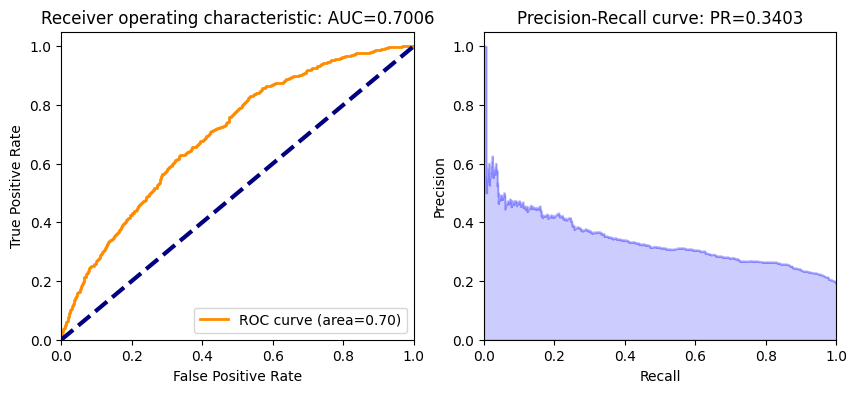

In [119]:
ROC_AUC(rf_v5,test_hex,'loan_default')

By halving the data in the over-sampling section, or say the good applicants, the values of both AUC and average precision increased while keeping the same parameters. They respectively increased from 0.65 to 0.7 and from 0.31 to 0.34. 

Both the ROC result and the PR result performed better compared to adjusting for under-sampling. Therefore, further analysis of the model after adjusting for the **over-sampling** will follow.

# 5. Insight

Further analysis of the model after adjusting for the under-sampling.

## 5.1 Gains Table

In [121]:
createGains(rf_v5)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/30 17:57", "2017/3/31 13:10", "2017/3/31 17:49", "2017/3/31 19:53", "2017/3/31 21:55", "2017/4/1 11:04", "2017/4/1 11:56", "2017/4/1 13:11", "2017/4/1 14:45", "2017/4/1 15:32", ...812 not listed..., "2017/7/8 7:13", "2017/7/8 9:46", "2017/7/9 10:25", "2017/7/9 11:08", "2017/7/9 15:07", "2017/7/9 17:54", "2017/7/9 18:06", "2017/7/9 22:02", "2017/7/9 23:27", "2017/7/9 9:19"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["KINGSUN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,134,186,320,134,186,0.22,0.07,60.0,2.23,15.0,41.88
1,320,86,234,640,220,420,0.37,0.16,120.0,1.83,21.0,34.38
2,320,81,239,960,301,659,0.50,0.25,180.0,1.67,25.0,31.35
3,320,76,244,1280,377,903,0.63,0.35,240.0,1.57,28.0,29.45
4,320,57,263,1600,434,1166,0.72,0.45,300.0,1.45,27.0,27.12
5,320,67,253,1920,501,1419,0.84,0.55,360.0,1.39,29.0,26.09
6,320,37,283,2240,538,1702,0.90,0.65,420.0,1.28,25.0,24.02
7,320,33,287,2560,571,1989,0.95,0.76,480.0,1.19,19.0,22.30
8,320,17,303,2880,588,2292,0.98,0.88,540.0,1.09,10.0,20.42


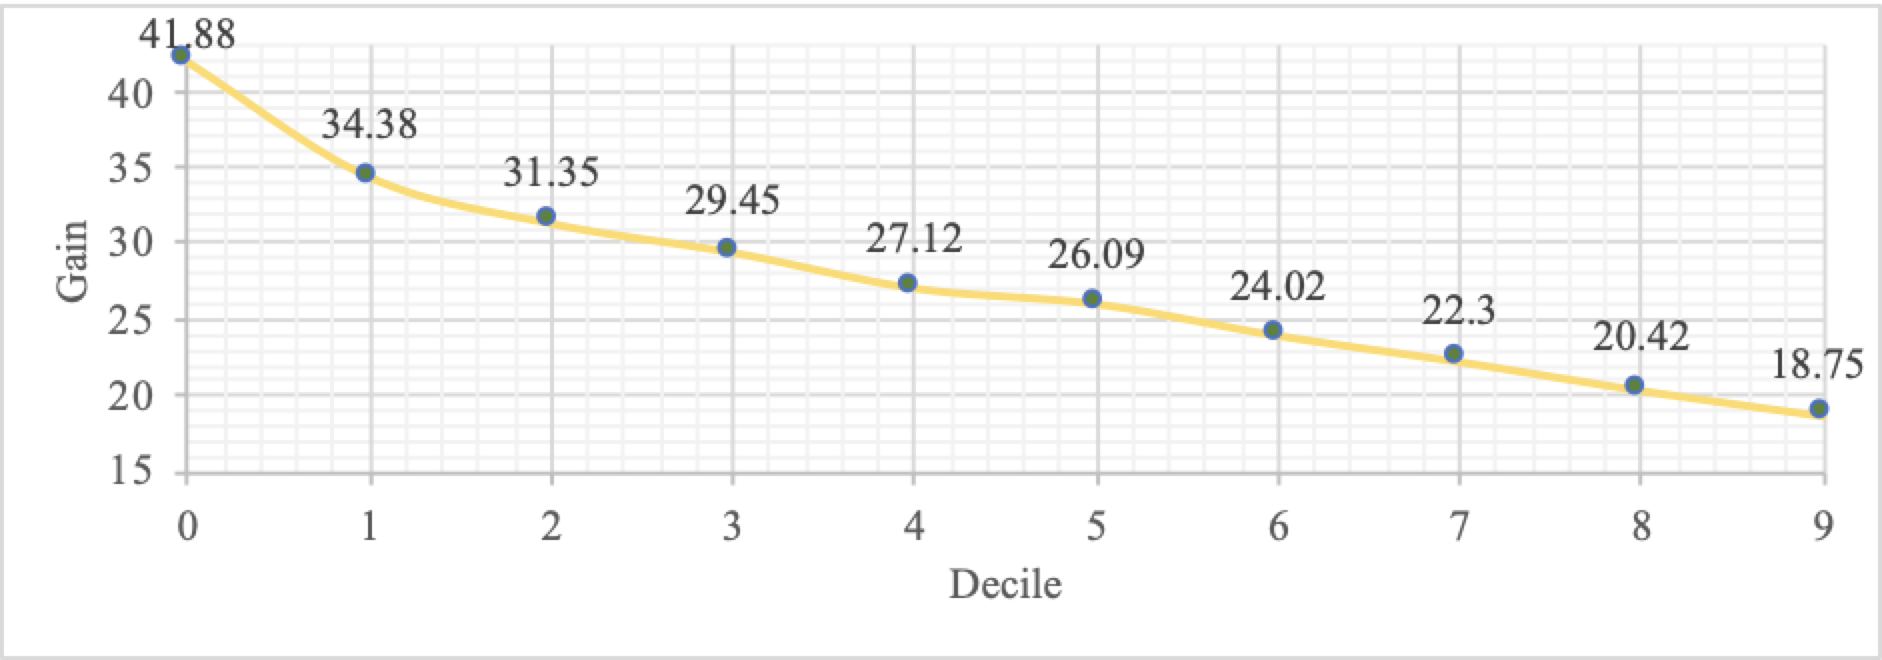

According to the results, combining the mortgage business insight, there will be 41.88% (0.4188 * 320 = 134) customer in decile 0 are bad loan applicants.

Since gain = cum_actual / cum_count, the bank could avoid 73.91% (1 - 26.09%) of bad loan applicants by avoiding lending to applicants in Decile 0 through Decile 5.

Comparison with the results before the adjustment shows that **the adjusted model identifies more frauds in the first few deciles.**

## 5.2 Lift

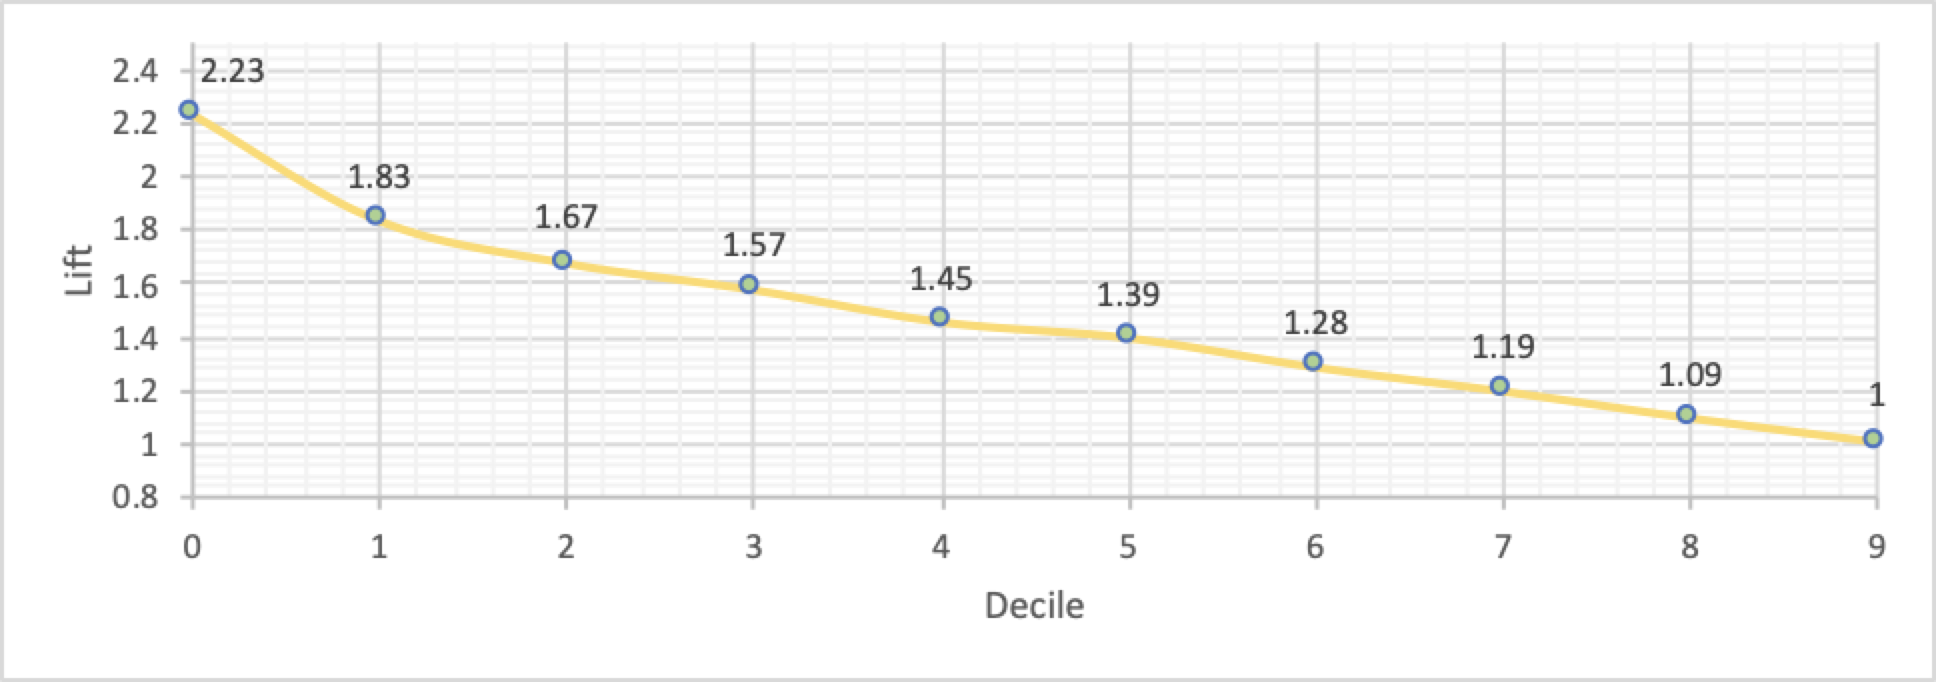

lift = cum_actual / if_random, which shows how much the bank can avoid bad applicants compared to banks randomly granting loans to customers.

Based on the results of the linear visualization between lift and Decile, it can be seen that the slope is most dramatic between Decile 3 to Decile 4. Therefore, from the lift perspective, the bank should avoid applicants located through Decile 0 to **Decile 4**. 

**The suggestion is more close to the suggestion from gains table than the before model.**

## 5.3 K-S

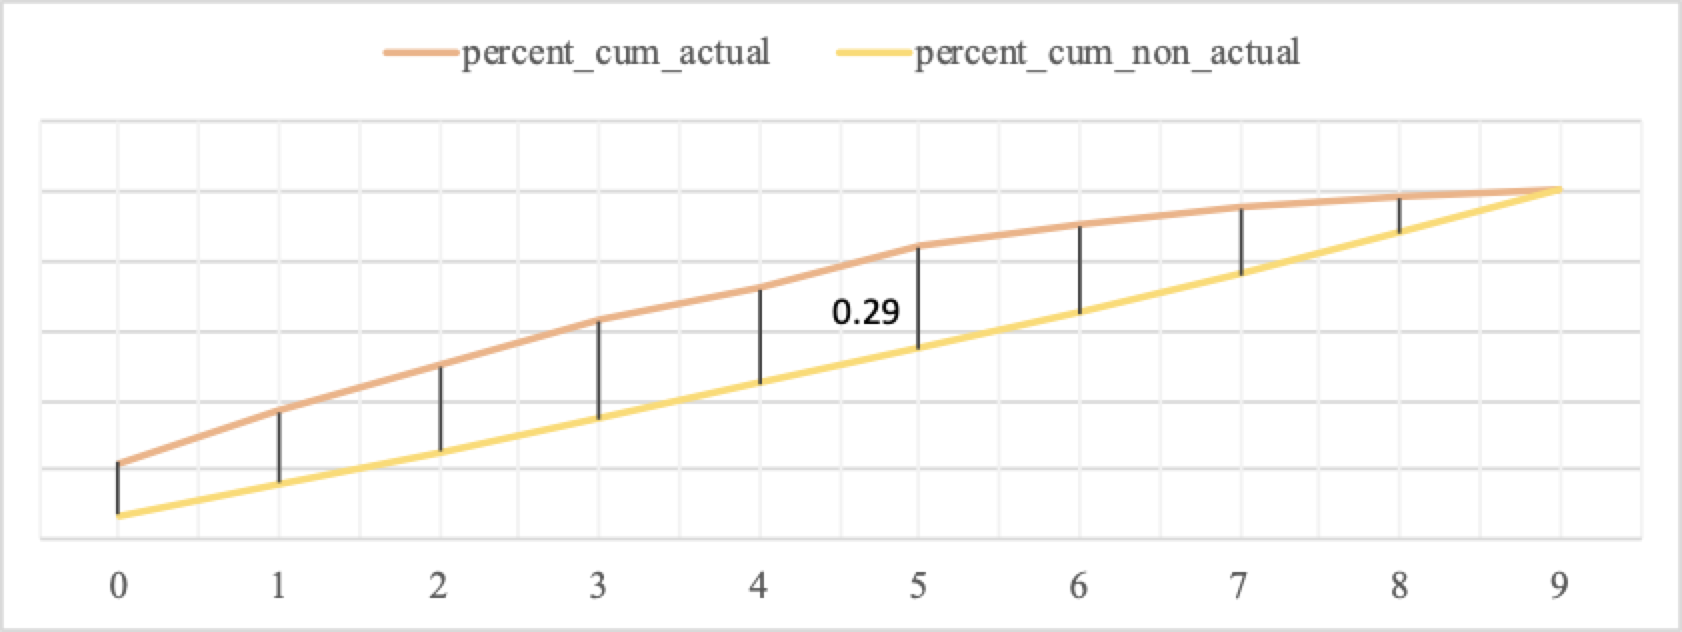

Frist of all, the K-S value for each deciles is not all 0, therefore the model effectively separate bad applicants from all customers. According to the figure above, I also find that the K-S value of Decile 5 reach to the maximum value of 0.29. In other words according to the results of K-S, the bank should avoid applicants located through Decile 0 to Decile 5.

**`Summary：`**


Taking all the above analysis into account, I think if the bank wants to expand its loan business, it can consider applicants from Decile 5 to Decile 9; if the bank wants to recover most of the loans securely and ensure profitability, it should consider applicants from Decile 6 to Decile 9.